In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import widgets

In [2]:
# local matrix of phi
S = np.array([[2/3,-1/6,-1/3,-1/6],[-1/6,2/3,-1/6,-1/3],[-1/3,-1/6,2/3,-1/6],[-1/6,-1/3,-1/6,2/3]])

In [3]:
def setValues(n):
    # calculate number of points
    points = 3*n*n + 4*n + 1
    # number of elements
    elements = 3*n*n
    # length of side of one element
    side = 1/n
    return points, elements, side

def getB(n,points,elements,side):
    # move from local matrices into global B matrix
    B = np.zeros((points,points))
    # upper elements
    # [*] [*]
    #     [ ]
    row = 2*n+1
    # helper transformation function
    def transf(el):
        left_up = el + el//(row-1)
        left_down = left_up + row
        right_down = left_down + 1
        right_up = left_up + 1
        transformation = [(0,left_down),(1,right_down),(2,right_up),(3,left_up)]
        return transformation

    for element in range(2*elements//3):
        transformation = transf(element)
        for tr1 in transformation:
            for tr2 in transformation:
                B[tr1[1],tr2[1]] += S[tr1[0],tr2[0]]

    # lower elements
    # [ ] [ ]
    #     [*]
    starting = n * (row + 1)
    row = n+1
    def transf(el):
        left_up = starting + el + el//(row-1)
        left_down = left_up + row
        right_down = left_down + 1
        right_up = left_up + 1
        transformation = [(0,left_down),(1,right_down),(2,right_up),(3,left_up)]
        return transformation

    for element in range(1*elements//3):
        transformation = transf(element)
        for tr1 in transformation:
            for tr2 in transformation:
                B[tr1[1],tr2[1]] += S[tr1[0],tr2[0]]
    return B

In [4]:
def g(x):
    return (x**2)**(1/3) # weird things with complex numbers

def getL(n,points,elements,side):
    # right side
    L = np.zeros((points,1))
    # upper boundary
    for lala in range(2*n):
        # left up
        x_star = -1.0 + side/2 + lala*side
        approx = 1/2*g(x_star)*side
        L[lala] += approx
        L[lala+1] += approx

    # lower boundary
    lowest = points - n - 1
    for lala in range(n):
        x_star = 0.0 + side/2+lala*side
        approx = 1/2*g(x_star)*side
        L[lowest + lala] += approx
        L[lowest+lala + 1] += approx

    # left boundary
    for lala in range(n):
        approx = 1/2*side
        L[lala*(2*n+1)] += approx
        L[(lala+1)*(2*n+1)] += approx

    # right upper boundary
    for lala in range(n):
        approx = 1/2*side
        L[lala*(2*n+1) + 2*n] += approx
        L[(lala+1)*(2*n+1) + 2*n] += approx

    # right lower boundary
    lowest = n*(2*n+1)+2*n
    for lala in range(n):
        approx = 1/2*side
        L[lowest + lala*(n+1)] += approx
        L[lowest + (lala+1)*(n+1)] += approx
    return L

In [5]:
# find elements on Dirchlets boundary
def getDs(n,points, B, L):
    dirchlets = []
    lowest = (2*n+1)*n
    for lala in range(n+1):
        dirchlets.append(lowest + lala)
    lowest = lowest + 2*n + 1
    for lala in range(n):
        dirchlets.append(lowest + lala*(n+1))

    # force them on B and L
    for d in dirchlets:
        B[d,:] = np.zeros(points)
        B[:,d] = np.zeros(points)
        B[d,d] = 1.0
        L[d] = 0.0

In [6]:
# solve the equation
def solve(n, points, side, B, L):
    X = np.linalg.solve(B,L)
    X = X[:,0]
    Xs = np.zeros(points)
    Ys = np.zeros(points)
    for la in range(n+1):
        for lal in range(2*n+1):
            Xs[lal+la*(2*n+1)] = -1.0 + side*lal
            Ys[lal+la*(2*n+1)] = -1.0 + side*la
    latest = (2*n+1)*(n+1)
    for la in range(n):
        for lal in range(n+1):
            Xs[latest+lal+la*(n+1)] = 0.0 + side*lal
            Ys[latest+lal+la*(n+1)] = 0.0 + side*(la+1)
    return Xs, Ys, X

In [7]:
def plotCoefs(fig, Xs, Ys, X):
    ## Plot elements coefficients as rough approximation of final shape
    ax = fig.add_subplot(121, projection='3d', title="Elements coeficients")
    ax.set_xlim(left=-1.0,right=1.0)
    ax.set_ylim(bottom=-1.0,top=1.0)
    ax.view_init(50.0,120)
    ax.scatter(Xs,Ys,X)
    # plt.show()


In [8]:
def plotElems(fig, n, points, side, Xs, Ys, X):
    resolution = 20
    def phi(x,y,cx,cy):
        if abs(x-cx)>side or abs(y-cy)>side:
            return 0.0
        if x > cx:
            a = 1.0 - (x-cx)/side
        else:
            a = (x-cx+side)/side
        if y > cy:
            b = 1.0 - (y-cy)/side
        else:
            b = (y-cy+side)/side
        return a*b

    Final = [[],[],[]]
    for x in range(-resolution,resolution):
        for y in range(-resolution,resolution):
            Final[0].append(x/resolution)
            Final[1].append(y/resolution)
            pointed = 0.0
            for ph in range(points):
                pointed += X[ph]*phi(x/resolution,y/resolution,Xs[ph],Ys[ph])
            Final[2].append(pointed)

    ## Plot final sum of elements with specified resolution
    ax = fig.add_subplot(122, projection='3d', title = "Sum of elements")
    ax.set_xlim(left=-1.0,right=1.0)
    ax.set_ylim(bottom=-1.0,top=1.0)
    ax.view_init(50.0,120)
    ax.plot_trisurf(Final[0],Final[1],Final[2],cmap=plt.cm.coolwarm,linewidth=0)
    plt.show()

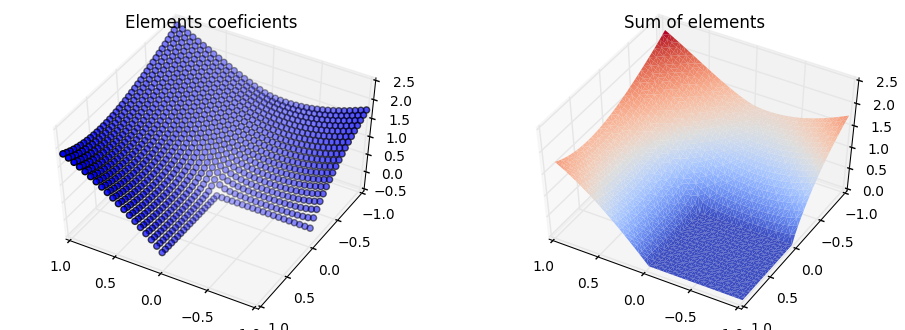

In [9]:
def heat(n=2):
    points, elements, side = setValues(n)
    B = getB(n, points, elements, side)
    L = getL(n, points, elements, side)
    getDs(n, points, B, L)
    Xs, Ys, As = solve(n, points, side, B, L)
    fig = plt.figure(figsize=plt.figaspect(0.35))
    plotCoefs(fig, Xs, Ys, As)
    plotElems(fig, n, points, side, Xs, Ys, As)
    
widgets.interactive(heat, n=(1,50,1), __manual=True)